In [1]:
!nvidia-smi
!pip install tensorboardcolab
!mkdir lib
!mv data_preprocess.py lib

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

from tensorboardcolab import TensorBoardColab
tbc = TensorBoardColab(graph_path='/content/sample_data')

Tue Oct 29 10:36:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
http://79427afd.ngrok.io


In [1]:
import re
import nltk
import sklearn
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from pprint              import pprint
from bokeh.io            import output_notebook, show
from bokeh.models        import ColumnDataSource
from bokeh.palettes      import Spectral6
from bokeh.plotting      import figure
from lib.data_preprocess import Preprocess
from nltk.corpus         import stopwords 
from nltk.tokenize       import word_tokenize
from nltk.stem           import WordNetLemmatizer
from bs4                 import BeautifulSoup
from PIL                 import Image
from wordcloud           import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm                import tqdm_notebook as tqdm
from scipy               import stats

# plot setting
output_notebook()
sns.set_style('whitegrid')
param = {'figure.figsize': (16, 8),
         'axes.titlesize': 18,
         'axes.labelsize': 16}
plt.rcParams.update(param)

# ntlk setting
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

%load_ext tensorboard

Loading BokehJS ...

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yihsiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yihsiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yihsiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data preprocessing

In [3]:
train_path   = 'dataset/labeledTrainData.tsv'
add_path     = 'dataset/unlabeledTrainData.tsv'
test_path    = 'dataset/testData.tsv'
twitter_path = 'dataset/tweets_sentiment.csv'

# read in the dataset
pp                = Preprocess()
add_df            = pd.read_csv(add_path, error_bad_lines=False, delimiter='\t')
train_df, test_df = pp.read_file(train_path, test_path, sep='\t')


# record the twitter and train dataframe size
labeled_ds_size = train_df.shape[0]

# check for missing value
print('Training set:')
pp.check_na(train_df)
print()

# check for missing value
print('Additional data set:')
pp.check_na(add_df)
print()

print('Test set:')
pp.check_na(test_df)
print()

b'Skipping line 43043: expected 2 fields, saw 3\n'


Training set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 3
========== Missing Data Info ==========
     Columns  Count DataType
0         id      0   object
1  sentiment      0    int64
2     review      0   object

Additional data set:
============== Data Info ==============
Number of rows: 49998
Number of cols: 2
========== Missing Data Info ==========
  Columns  Count DataType
0      id      0   object
1  review      0   object

Test set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 2
========== Missing Data Info ==========
  Columns  Count DataType
0      id      0   object
1  review      0   object



In [8]:
add_df[:3][['review', 'id']]

,review,id
0,"Watching Time Chasers, it obvious that it was ...",9999_0
1,I saw this film about 20 years ago and remembe...,45057_0
2,"Minor Spoilers<br /><br />In New York, Joan Ba...",15561_0


In [5]:
pd.concat([train_df[:3], add_df[:3][['review', 'id']])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,id,review,sentiment
0,5814_8,with all this stuff going down at the moment w...,1.0
1,2381_9,the classic war of the worlds by timothy hine...,1.0
2,7759_3,the film starts with a manager nicholas bell g...,0.0
0,9999_0,"Watching Time Chasers, it obvious that it was ...",NaN
1,45057_0,I saw this film about 20 years ago and remembe...,NaN
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba...",NaN


In [4]:
def text_process(df):
    # convert it to lower space
    df.review = df.review.str.lower()

    # pattern
    nw_removal  = lambda review: re.sub(r'[^A-Za-z\s]' , ' ', review)
    spc_removal = lambda review: re.sub(r'[\s]+'      , ' ', review)
    tag_removal = lambda review: BeautifulSoup(review, 'lxml').get_text()

    # replace words or substrings which match the pattern
    df.review = df.review.apply(tag_removal)
    df.review = df.review.apply(nw_removal)
    df.review = df.review.apply(spc_removal)
    
    return df

def lemmatize(review):
    lemmatization = WordNetLemmatizer()
    stop_words    = set(stopwords.words('english'))
    
    # tokenize, lemmatize and stop words removal
    tokens            = word_tokenize(review)
    lemmatized_tokens = list(map(lambda x: lemmatization.lemmatize(x, pos='v'), tokens))
    meaningful_tokens = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    
    return meaningful_tokens

# obtaining the stop words
stop_words = set(stopwords.words('english'))

# add in the additional dataset
train_df = pd.concat([train_df, add_df])

# clean the reviews
train_df = text_process(train_df)
test_df  = text_process(test_df)

# lemmatize the reviews
train_df['review_tokenized'] = list(map(lemmatize, train_df.review.values.copy()))
test_df['review_tokenized']  = list(map(lemmatize, test_df.review.values.copy()))
all_reviews                  = pd.concat([train_df['review_tokenized'], test_df['review_tokenized']]).to_numpy()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



KeyboardInterrupt: 

In [5]:
display(train_df[['id', 'review', 'sentiment']].head(10))

,id,review,sentiment
0,5814_8,with all this stuff going down at the moment w...,1.0
1,2381_9,the classic war of the worlds by timothy hine...,1.0
2,7759_3,the film starts with a manager nicholas bell g...,0.0
3,3630_4,it must be assumed that those who praised this...,0.0
4,9495_8,superbly trashy and wondrously unpretentious s...,1.0
5,8196_8,i dont know why people think this is such a ba...,1.0
6,7166_2,this movie could have been very good but comes...,0.0
7,10633_1,i watched this video at a friend s house i m g...,0.0
8,319_1,a friend of mine bought this film for and even...,0.0
9,8713_10,this movie is full of references like mad max ...,1.0


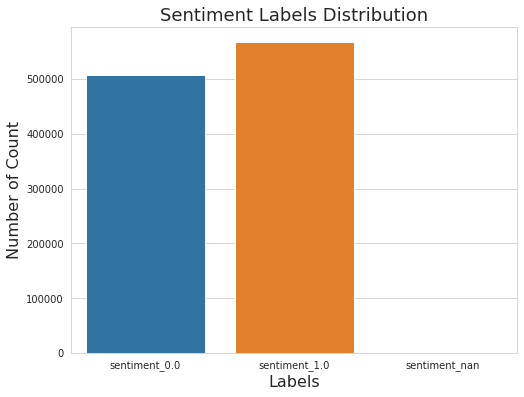

In [6]:
labels, counts = np.unique(train_df.sentiment.values, return_counts=True)
labels         = ['sentiment_' + str(label) for label in labels]

plt.figure(figsize=(8,6))
plt.title('Sentiment Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Count')
sns.barplot(x=labels, y=counts)
plt.show()



In [0]:
def get_high_frequent_word(feature_name, tokenized_reviews, max_length=200):
    word_count = {w: 0 for w in feature_name}

    for tokens in tokenized_reviews:
        for w in tokens:
            if w in word_count.keys():
                word_count[w] += 1
                
    high_frequent_words = np.array(sorted(word_count.items(), key = lambda kv:(kv[1], kv[0])))    
                
    return high_frequent_words[-max_length:,0]



In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# plotting wordcloud
# stop_words   = set(stopwords.words('english'))
# bad_review   = train_df.loc[train_df['sentiment'] == 0]
# good_review  = train_df.loc[train_df['sentiment'] == 1]

vectorizer   = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=500)
bad_vct      = vectorizer.fit_transform(bad_review['review'].values.copy())
hf_words     = get_high_frequent_word(vectorizer.get_feature_names(), bad_review['review_tokenized'].values.copy())
bad_review   = " ".join(w for w in hf_words)
bad_wdcloud  = WordCloud(stopwords=stop_words, background_color="white").generate(bad_review)

vectorizer   = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=500)
good_vct     = vectorizer.fit_transform(good_review['review'].values.copy())
hf_words     = get_high_frequent_word(vectorizer.get_feature_names(), good_review['review_tokenized'].values.copy())
good_review  = " ".join(w for w in hf_words)
good_wdcloud = WordCloud(stopwords=stop_words, background_color="white").generate(good_review)

plt.figure(figsize=(16,6))
plt.imshow(good_wdcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(16,6))
plt.imshow(bad_wdcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: ignored

In [0]:
review_length = np.array(list(map(len, all_reviews.copy())))
mode          = stats.mode(review_length)[0][0]
mean          = np.mean(review_length)
median        = np.median(review_length)
ymin, ymax    = 0, 0.2

plt.figure(figsize=(16,8))
plt.title('Words per Review')
plt.xlabel('Number of Words in each Review')
plt.xlim([0, np.percentile(review_length, 95)])  # check where the 95% of distribution lies on
plt.ylim([0, ymax])

plt.vlines(mode  , ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='red'  , label=f'mode={mode}')
plt.vlines(mean  , ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='blue' , label=f'mean={mean}')
plt.vlines(median, ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='green', label=f'median={median}')
sns.distplot(review_length)

plt.legend()
plt.show()


In [0]:
from gensim.models import Phrases

bigrams  = Phrases(sentences=all_reviews)
trigrams = Phrases(sentences=bigrams[all_reviews])

# Word Embedding

In [7]:
%%time
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences

embedded_size = 300
embedding = Word2Vec(sentences=trigrams[bigrams[all_reviews]],
                     size=embedded_size, window=5, min_count=3, workers=-1)

print('Vocabulary size: {}'.format(len(embedding.wv.vocab)))

Vocabulary size: 194802
CPU times: user 3min 59s, sys: 625 ms, total: 3min 59s
Wall time: 3min 59s


In [0]:
train_size = labeled_ds_size
train_data = train_df[:train_size]
train_x, train_y = train_data['review_tokenized'].values.copy(), train_data['sentiment'].values.copy()
# train  , valid   = pp.train_valid_split(train_df[:train_size], split=0.95, seed=0)
# train_x, valid_x = train.review_tokenized.values.copy(), valid.review_tokenized.values.copy()
# train_y, valid_y = train.sentiment.values.copy()       , valid.sentiment.values.copy()

from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.05, shuffle=True, random_state=42)

In [9]:
def vectorized_sentence(reviews, vocab):
    print('Vectorizing words.....', end='\r')
    
    keys           = list(vocab.keys())
    filter_unknown = lambda word  : vocab.get(word, None) is not None
    encode         = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized     = list(map(encode, reviews))
    
    print('Vectorizing words..... (done)')
    
    return vectorized


vocab   = embedding.wv.vocab
train_x = vectorized_sentence(trigrams[bigrams[train_x]], vocab)
valid_x = vectorized_sentence(trigrams[bigrams[valid_x]], vocab)

pad_length  = 150 
train_pad_x = pad_sequences(sequences=train_x, maxlen=pad_length, padding='post')
valid_pad_x = pad_sequences(sequences=valid_x, maxlen=pad_length, padding='post')

Vectorizing words..... (done)
Vectorizing words..... (done)


# Model Development

In [0]:
import tensorflow as tf

from keras.models            import Sequential
from keras.layers            import Dense, Dropout, Bidirectional, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers        import Adam
from keras.callbacks         import TensorBoard, LearningRateScheduler, Callback


def Bidirectional_LSTM(embedding_matrix, input_length):
    embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1], 
                                input_length=input_length,
                                weights=[embedding_matrix],
                                trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def lr_scheduler(epochs):
    lr = 0.001
    
    if epochs > 20  : lr = 0.0003;
    elif epochs > 40: lr = 0.0001;
    elif epochs > 60: lr = 0.00003;
        
#     tf.summary_scalar('learning_rate', data=lr, step=epochs)
    
    return lr

class LossCallback(Callback):
    def on_train_begin(self, logs={}):
        self.history = []
        
    def on_batch_end(self, batch, logs={}):
        self.history.append(logs.get('loss'))


In [11]:
net   = Bidirectional_LSTM(embedding.wv.vectors, pad_length)
optim = Adam(lr=0.0003, decay=0.2)
net.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
net.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          58440600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_______________________________

In [0]:
epochs       = 200
batch_size   = 200
log_dir      = '/content/sample_data/'
tb_callbacks = TensorBoard(log_dir=log_dir + 'accuracy/')
ls_callbacks = LossCallback()

# lr_writer    = tf.summary.create_file_writer(log_dir + 'dynamic_lr/')
lr_callbacks = LearningRateScheduler(lr_scheduler)

In [0]:
%%time

print('Training....', end='\r')

history = net.fit(x=train_pad_x, 
                y=train_y, 
                validation_data=(valid_pad_x, valid_y), 
                batch_size=batch_size, 
                epochs=200,
                verbose=0,
                callbacks=[tb_callbacks])

print('Training.... (Done)')
print('Average Loss:', np.average(ls_callbacks.history))


In [0]:
f model_save(model):
#     # save the model
#     model_json = model.to_jason()
    
#     # save the model parameters to json file
#     with open('gdrive/My Drive/dataset/IMDB/model.json', 'w') as json_file:
#         json_file.write(net_json)
        
    # save the weights to h5 file
    model.save_weights('gdrive/My Drive/dataset/IMDB/model.h5')
    
model_save(net)


# Metrics

In [0]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_curve, auc

val_y_   = net.predict(val_pad_x)

plt.figure(figsize=(16,8))
plt.title('Confusion matrix on Validation set')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
sns.heatmap(cm(val_y, val_y_))
plt.show()


In [14]:
fpr, tpr, threshold = roc_curve(val_y, val_y_)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(16,8))
plt.title('AUC, ROC score')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, label=f"AUC score: {auc_score}")
plt.show()

NameError: ignored